# A notebook for pulling the run data from wandb for TALES and creating the various figures and tables used in our paper and website.

## Data pre-processing
Relevant Variables:
- tmp: dataframe with all of the run info
- framework_games: a dictionary of the form {framework: [all games in framework]}. Useful for checking and making sure that every llm has at least one game run
- llm_framework_scores: a dictionary of the form {llm: {framework: {game: {seed: [best_score, tokens_used]}}}}

### These cells do the following:
- Initialize the wandb api
- Pull all the runs according to certain filters ('conversation: True')
- Dump the runs into a pandas dataframe
- Print the number of total games per llm (This should be 615 if all games were run 615 = 123 * 5)

In [1]:
#Workspace you want to pull runs from
wandb_workspace = "text-games-benchmark"

# Where you want the logged format texts to be stored (option for more complicated file structures later down)
base_path = '/root/logs/'

# Divider between each step. Change as wanted
divider_string = "\n************************************************************************************************\n"

# The specific chain of thought prompt: probably not needed, will remove in the future
COT_SYS_PROMPT = """You are playing a text-based game and your goal is to finish it with the highest score. Upon reading the text observation, generate a plan with subgoals when asked to think step-by-step, then provide a *single* short phrase to interact with the game when asked to do so, e.g. `get lamp` (without the backticks). When stuck, try using the `help` command to see what commands are available."""

In [2]:
import wandb
import os
import json
import numpy as np

api = wandb.Api()

In [3]:
import pandas as pd
filter ={
            "config.conversation": True,
        }

runs = api.runs(path="text-games-benchmark", filters = filter)
run_cutoff = "2024-02-0"
files_skipped = 0
path = base_path # Change to your file path
runs_data = []
for run in runs:
    if 'without-help' not in run.tags:
        run_data = dict(run.summary)
        run_data.update(run.config)
        run_data['tags'] = run.tags
        run_data['run_object'] = run

        # Download the artifact to extract the rollout. This can take a while if you haven't downloaded them before so I would recommend commenting them out if not needed
        file_path = run._summary['episode/rollout']['path']
        full_path = path + file_path
        try:
            if not os.path.exists(full_path): # If the log has not been downloaded, download it
                print("Downloading file", full_path)
                for file in run.files():
                    if "rollout" in file.name:
                        file.download(base_path, exist_ok=True)
            with open(full_path) as json_file: log = json.load(json_file)
            run_data['rollout'] = log['data']
        except:
            print("Could not get trajectory for run", run.name)
            files_skipped += 1
            if files_skipped > 5:
                break

        run_data["agent"] = run.config["agent"]
        run_data["game"] = run.config["game"]
        runs_data.append(run_data)
print(len(runs_data))
runs_df = pd.DataFrame(runs_data)

22065


In [4]:
# Filter the runs
def regen_and_filter_df(all_games_required = True, all_seeds_required = False, print_counts = False):
    tmp = runs_df
    tmp = tmp[tmp['conversation'] == True]
    tmp1 = tmp[tmp['agent_type'] == 'zero-shot']
    tmp2 = tmp[tmp['agent_type'] == 'react']
    # tmp = tmp[tmp['agent_type'] == 'zero-shot']
    tmp = pd.concat([tmp1, tmp2])
    tmp = tmp[tmp['llm'] != 'claude-3.5-sonnet']
    tmp = tmp[tmp['llm'] != 'o3-mini']
    tmp = tmp[tmp['game'] != 'JerichoEnvTheatre']
    tmp = tmp[~tmp['tags'].apply(lambda tags: 'without-help' in tags)]

    # Check for if there is an llm with multiple agent types: If so, add designation
    llm_agent_counts = tmp.groupby('llm')['agent_type'].nunique()
    llms_with_multiple_types = llm_agent_counts[llm_agent_counts > 1].index.tolist()

    for llm in llms_with_multiple_types:
        for agent_type in tmp[tmp['llm'] == llm]['agent_type'].unique():
            mask = (tmp['llm'] == llm) & (tmp['agent_type'] == agent_type)
            tmp.loc[mask, 'llm'] = f"{llm} ({agent_type})"

    if all_games_required:
        print("Requiring all games...")
        # If the llm has all games, this value should be 
        game_counts = tmp.groupby('llm')['game'].nunique()
        llms_with_enough_games = game_counts[game_counts >= 122].index.tolist()
        tmp = tmp[tmp['llm'].isin(llms_with_enough_games)]

    if all_seeds_required:
        print("Requiring all seeds...(implicitly requiring all games too)")
        seed_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size()
        llms_with_enough_seeds = seed_counts[seed_counts >= 610].index.tolist()
        tmp = tmp[tmp['llm'].isin(llms_with_enough_seeds)]

    llm_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size().reset_index(name='total_games')

    if print_counts: print(llm_counts)

    return tmp

tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = True)

Requiring all games...
Requiring all seeds...(implicitly requiring all games too)
                                                  llm  total_games
0                           Qwen/Qwen2.5-72B-Instruct          610
1                            Qwen/Qwen2.5-7B-Instruct          610
2                                    claude-3.5-haiku          610
3                            claude-3.5-sonnet-latest          610
4                           claude-3.7-sonnet (react)          610
5                       claude-3.7-sonnet (zero-shot)          610
6                             deepseek-ai/DeepSeek-R1          610
7           deepseek-ai/DeepSeek-R1-Distill-Llama-70B          610
8                                    gemini-2.0-flash          610
9                                              gpt-4o          610
10                                        gpt-4o-mini          610
11                 meta-llama/Llama-3.1-405B-Instruct          610
12                  meta-llama/Llama-3.1-70B-In

### Get a dictionary of the form {llm: {framework: {game: {seed: best_score}}}} to make things easier later

In [5]:
import random
num_runs = 0
num_traj = 0
avg_last_rewarded_step = 0
rewarded_trajs = 0
filtered_runs_data = tmp.to_dict(orient='records')
data = random.choice(filtered_runs_data)
print(data.keys())
all_frameworks = tmp['framework'].unique()
all_llms = tmp['llm'].unique()
print(all_frameworks)
# Could just do tmp['framework'].unique() but this enforces ordering
fws = ['textworld', 'textworld_express', 'alfworld', 'scienceworld', 'jericho']
# store everything in a dictionary of the form {llm: {framework: {game: {seed: best_score}}}}
llm_framework_scores = {} 

# Iniitialize the LLM layer of the dictionary
for llm in all_llms:
    llm_framework_scores[llm] = {}

# Initialize the framework layer of the dictionary
for framework in fws:
    for llm in all_llms:
        llm_framework_scores[llm][framework] = {}   

# For game and seeds, its easier to just iterate through the filtered_runs_data
for data in filtered_runs_data:
    game = data['game']
    seed = data['seed']

    if game not in llm_framework_scores[data['llm']][data['framework']].keys():
        llm_framework_scores[data['llm']][data['framework']][game] = {}
    

    # Get the max score reached
    max_score = -1000000
    if 'rollout' not in data.keys():
        llm_framework_scores[data['llm']][data['framework']][game][seed] = 0
        continue
    for step in data['rollout']:
        if step[3] > max_score:
            max_score = step[3]

    tokens_used = data['episode/token_usage']
    llm_framework_scores[data['llm']][data['framework']][game][seed] = [max_score, tokens_used]

# Uncomment to count the number of runs for each LLM to sanity check
# for llm in all_llms:
#     total_runs = 0
#     for framework in fws:
#         relevant_games = llm_framework_scores[llm][framework]
#         for game, seeds in relevant_games.items():
#             total_runs += len(seeds)
#     print("LLM: ", llm)
#     print("Total runs: ", total_runs)

dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves', 'episode/normalized_score', 'episode/rollout', 'episode/score', 'final/Duration', 'final/Game Max Score', 'final/Highscore', 'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves', 'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins', 'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework', 'max_steps', 'conversation', 'admissible_commands', 'tags', 'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed', 'context_limit', 'episode/highscore', 'episode/normalized_highscore', 'episode/token_usage', 'agent_type', 'version', 'reasoning_effort'])
['scienceworld' 'textworld' 'alfworld' 'jericho' 'textworld_express']


In [6]:
llm_framework_scores['o1']['textworld_express']['TWXCookingWorld']

{202411063: [0.42, 2530.0],
 202411064: [0.42, 2235.0],
 202411065: [0.42, 2746.0],
 202411061: [0.42, 2072.0],
 202411062: [0.42, 2194.0]}

### Make a dictionary of all frameworks and games
- Useful for when you want to check that every game has at least one run. Of the form {framework: [games]}

In [7]:
# Make a dictionary of the form {framework: [games]} to make things easier
framework_games = {}
for framework in fws:
    framework_games[framework] = []
    for llm in all_llms:
        relevant_games = llm_framework_scores[llm][framework]
        for game, seeds in relevant_games.items():
            if game not in framework_games[framework]:
                framework_games[framework].append(game)

print(framework_games)

{'textworld': ['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10'], 'textworld_express': ['TWXCookingWorld', 'TWXTextWorldCommonsense', 'TWXCoinCollector', 'TWXArithmetic', 'TWXMapReader', 'TWXSorting', 'TWXSimonSays10', 'TWXSimonSays50', 'TWXSimonSays100', 'TWXSimonSaysWithMemory10', 'TWXSimonSaysWithMemory50', 'TWXSimonSaysWithMemory100', 'TWXSimonSaysWithMemory10Verbose', 'TWXSimonSaysWithMemory50Verbose', 'TWXSimonSaysWithMemory100Verbose', 'TWXPeckingOrder'], 'alfworld': ['ALFWorldPickAndPlaceSimpleSeen', 'ALFWorldLookAtObjInLightSeen', 'ALFWorldPickCleanThenPlaceInRecepSeen', 'ALFWorldPickHeatThenPlaceInRecepSeen', 'ALFWorldPickCoolThenPlaceInRecepSeen', 'ALFWorldPickTwoObjAndPlaceSeen', 'ALFWorldPickAndPlaceSimpleUnseen', 'ALFWorldLookAtObjInLightUnseen', 'ALFWorldPickCleanThenPlaceInRecepUnseen', 'ALFWorldPickHeatThenPlaceInRecepUnseen', 'AL

If you need to check why a model isn't appearing:

In [8]:
# one_llm = 'gemini-2.5-pro-preview-03-25'
one_llm = 'gemini-2.0-flash'
def get_missing_games(one_llm):
    tmp_one_llms = tmp[tmp['llm'] == one_llm]
    one_llm_games = tmp_one_llms['game'].unique()

    all_games = []
    for _, games in framework_games.items():
        all_games += games

    missing_games = []
    for game in all_games:
        if game not in one_llm_games:
            missing_games.append(game)
    return missing_games

print(get_missing_games('gemini-2.0-flash'))
print("______________________________________")
print(get_missing_games('gemini-2.5-pro-preview-03-25'))

[]
______________________________________
['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10', 'TWXCookingWorld', 'TWXTextWorldCommonsense', 'TWXCoinCollector', 'TWXArithmetic', 'TWXMapReader', 'TWXSorting', 'TWXSimonSays10', 'TWXSimonSays50', 'TWXSimonSays100', 'TWXSimonSaysWithMemory10', 'TWXSimonSaysWithMemory50', 'TWXSimonSaysWithMemory100', 'TWXSimonSaysWithMemory10Verbose', 'TWXSimonSaysWithMemory50Verbose', 'TWXSimonSaysWithMemory100Verbose', 'TWXPeckingOrder', 'ALFWorldPickAndPlaceSimpleSeen', 'ALFWorldLookAtObjInLightSeen', 'ALFWorldPickCleanThenPlaceInRecepSeen', 'ALFWorldPickHeatThenPlaceInRecepSeen', 'ALFWorldPickCoolThenPlaceInRecepSeen', 'ALFWorldPickTwoObjAndPlaceSeen', 'ALFWorldPickAndPlaceSimpleUnseen', 'ALFWorldLookAtObjInLightUnseen', 'ALFWorldPickCleanThenPlaceInRecepUnseen', 'ALFWorldPickHeatThenPlaceInRecepUnseen', 'ALFWorldPic

## Making and formatting table and charts for overleaf and the website.
- Alot of these I made it so that the output of the cell can just be copy-pasted into the appropriate table
- For updating the website with scores, you should just be able to run everything and the appropriate files will be saved in their respective folders.

### Get all of the scores and stds
- Need to run this for all of the following tables/charts

In [13]:
import numpy as np

def cast_to_float(s):
    try:
        return round(float(s), 3)
    except ValueError:
        return None  # Return None if the conversion fails
    
def get_all_scores_and_stds(llms, frameworks, require_all_frameworks = True, require_all_games = True, require_all_seeds = False, skip_llms = ['claude-3.5-sonnet'], skip_frameworks = [], verbose = False):
    scores_per_framework = []
    stds_per_framework = []
    # Literate through all llms:
    for llm in llms:
        # Skip the LLMs that are not in the list
        if llm in skip_llms: continue
        # Put the llm in the first position in the list
        scores = [llm]
        stds = [llm]
        all_framework_scores = []
        all_framework_stds = []
        all_frameworks = []

        # If all seeds have not been completed, add a * to the name
        all_seeds_done = True
        for framework in frameworks:
            # Grab the relevant games for the framework
            relevant_games = llm_framework_scores[llm][framework]

            all_tokens = []
            all_scores = []
            all_stds = []
            all_games = []
            for game, seeds in relevant_games.items():
                # Get the scores for the game per seed:
                token_seeds = []
                score_seeds = []
                all_games.append(game)
                for score_tokens in seeds.values():
                    score_seeds.append(score_tokens[0])
                    token_seeds.append(score_tokens[1])
                all_scores.append(np.mean(score_seeds))
                all_stds.append(np.std(score_seeds))
                all_tokens.append(np.mean(token_seeds))
                all_framework_scores.append(all_scores[-1])
                all_framework_stds.append(all_stds[-1])
                if len(seeds) < 4: 
                    all_seeds_done = False

            # if we are requiring all games, check if we have all the games
            missing_games = []
            if require_all_games:
                for game in framework_games[framework]: 
                    if game not in all_games: missing_games.append(game)
                if len(missing_games) != 0: 
                    if verbose: print(f'{llm} missing games {",".join(missing_games)} in {framework}')
                    continue

            # if we are requiring all seeds, check if we have all the seeds
            if require_all_seeds:
                for game, seeds in relevant_games.items(): 
                    if len(seeds) != 5: missing_games.append(game)
                if len(missing_games) != 0:
                    if verbose: print(f'{llm} missing seeds {",".join(missing_games)} in {framework}')
                    continue

            all_frameworks.append(framework)
            scores.append(cast_to_float(np.mean(all_scores)))
            stds.append(cast_to_float(np.mean(all_stds)))

        # if we are requiring all frameworks, check if we have all the frameworks
        if require_all_frameworks:
            if len(scores) != len(frameworks) + 1: # +1 offset for the llm
                missing_frameworks = []
                for framework in frameworks: 
                    if framework not in all_frameworks: missing_frameworks.append(framework)
                if len(missing_frameworks) != 0:
                    if verbose: print(f'{llm} missing frameworks {",".join(missing_frameworks)}')
                    continue

        # Append the per-game mean of all the scores to the end
        scores.append(cast_to_float(np.mean(all_framework_scores)))
        if not all_seeds_done: scores[0] += "*"
        scores_per_framework.append(scores) 

        # Append the per-game mean of all of the standard deviations to the end
        stds.append(cast_to_float(np.mean(all_framework_stds)))
        if not all_seeds_done: stds[0] += "*"
        stds_per_framework.append(stds)
    
    return scores_per_framework, stds_per_framework

scores_per_framework, stds_per_framework = get_all_scores_and_stds(
                                            llms = all_llms, 
                                            frameworks = fws, 
                                            require_all_frameworks = True, 
                                            require_all_games = True, 
                                            require_all_seeds = False, 
                                            skip_llms = ['claude-3.5-sonnet'], 
                                            skip_frameworks = [], 
                                            verbose = False)

In [14]:
def cast_to_str(value, sig_digits=3):
    if value == 0: return '0.' + '0' * sig_digits
    
    # Count sig figs after decimal
    sig_figs = len(str(value).split(".")[-1])

    # Count zeros to be added:
    trailing_zeros = sig_digits - sig_figs
    
    # Pad zeros
    string_value = str(value)
    for i in range(trailing_zeros): string_value += "0"

    return string_value

def sort_by_last_element(arr):
    return sorted(arr, key=lambda x: x[-1], reverse = True)

sorted_array = sort_by_last_element(scores_per_framework)
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")

# Padding them to have the &s line up because it makes my ocd happy
formatted_rows = []
for model in sorted_array:
    formattedRow = [model[0].split("/")[-1]]
    for score in model[1:]:
        formattedRow.append(cast_to_str(cast_to_float(score * 100), 1))
    formatted_rows.append(formattedRow)

Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall


### Print out a latex-formatted table of scores

In [15]:
max_model_len = max([len(row[0]) for row in formatted_rows])
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")
for row in formatted_rows:
    scores = " & " +  " & ".join(row[1:])
    print(f"{row[0]:<{max_model_len + 2}} {scores} \\\\")



Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall
claude-3.7-sonnet (react)                 & 97.3 & 91.3 & 83.3 & 76.5 & 12.5 & 52.5 \\
claude-3.7-sonnet (zero-shot)             & 97.3 & 95.8 & 81.7 & 72.4 & 13.0 & 52.1 \\
claude-3.5-sonnet-latest                  & 95.5 & 81.6 & 75.0 & 82.3 & 9.6 & 50.4 \\
o1                                        & 97.8 & 70.2 & 28.3 & 80.1 & 10.3 & 44.2 \\
gpt-4o                                    & 83.6 & 80.6 & 56.7 & 61.4 & 5.6 & 40.6 \\
claude-3.5-haiku                          & 94.9 & 79.8 & 26.7 & 67.3 & 5.0 & 39.6 \\
Llama-3.1-405B-Instruct                   & 90.9 & 79.2 & 31.7 & 51.8 & 6.1 & 36.4 \\
gemini-2.0-flash                          & 80.8 & 76.1 & 20.0 & 57.1 & 5.4 & 35.0 \\
Llama-3.3-70B-Instruct                    & 69.6 & 77.2 & 15.0 & 55.1 & 4.5 & 32.8 \\
Llama-3.1-70B-Instruct                    & 65.6 & 81.9 & 8.3 & 51.9 & 5.3 & 32.0 \\
Qwen2.5-72B-Instruct                      & 76.5 & 83.8 & 36

In [ ]:
def get_all_games_per_framework(tmp, framework):
    llm_games = {}

    all_games = sorted(framework_games[framework])
    print(len(all_games))

    for llm in tmp['llm'].unique():
        llm_name_formatted = llm.split("/")[-1]
        game_scores = []
        for game in all_games:
            # Basing this on Marc's code
            llm_filtered_tmp = tmp[tmp['llm'] == llm]
            framework_filtered_tmp = llm_filtered_tmp[llm_filtered_tmp['game'] == game]
            avg_score = framework_filtered_tmp.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
            avg_score.columns = ["seeds", "avg_normalized_highscore_per_episode"]
            game_scores.append(avg_score['avg_normalized_highscore_per_episode'].mean())

        llm_games[llm_name_formatted] = game_scores

    return llm_games, all_games

def generate_latex_table(table_string):
    # Split the string into lines and extract the header and rows
    lines = [line.strip() for line in table_string.strip().splitlines() if line.strip()]
    headers = [h.strip() for h in lines[0].split("&")]
    rows = [line.rstrip("\\").strip().split("&") for line in lines[1:]]

    # Clean up each row value
    cleaned_rows = [[cell.strip() for cell in row] for row in rows]

    # Start LaTeX table
    latex = []
    latex.append("\\begin{table}[ht]")
    latex.append("\\centering")
    latex.append("\\scriptsize")
    latex.append("\\setlength{\\tabcolsep}{3pt}")
    latex.append("\\renewcommand{\\arraystretch}{1.1}")
    latex.append("\\begin{tabular}{\\textwidth}{l" + "c" * (len(headers) - 1) + "}")
    latex.append("\\toprule")

    # Format header row
    formatted_headers = [headers[0]] + [f"\\rotatebox{{280}}{{{h}}}" for h in headers[1:]]
    latex.append(" & ".join(formatted_headers) + " \\\\")
    latex.append("\\midrule")

    # Format each data row
    for row in cleaned_rows:
        latex.append(" & ".join(row) + " \\\\")

    # Close table
    latex.append("\\bottomrule")
    latex.append("\\end{tabular}")
    latex.append("\\caption{Model performance across TWX tasks}")
    latex.append("\\label{tab:twx-models}")
    latex.append("\\end{table}")

    return "\n".join(latex)
            
all_games, game_titles  = get_all_games_per_framework(tmp, 'textworld')
header = " & ".join(["Models"] + game_titles)
for row in formatted_rows:
    scores = []
    for score in all_games[row[0]]:
        scores.append(cast_to_str(round(score * 100, 1), 1))
    all_scores_framework = "& " + " & ".join(scores)
    header += "\n" + f"{row[0]:<{max_model_len + 2}} {all_scores_framework} \\\\"

print(generate_latex_table(header).replace("TW", ""))
print(len(formatted_rows))

10
\begin{table}[ht]
\centering
\scriptsize
\setlength{\tabcolsep}{3pt}
\renewcommand{\arraystretch}{1.1}
\begin{tabular}{\textwidth}{lcccccccccc}
\toprule
Models & \rotatebox{280}{CookingLevel1} & \rotatebox{280}{CookingLevel10} & \rotatebox{280}{CookingLevel2} & \rotatebox{280}{CookingLevel3} & \rotatebox{280}{CookingLevel4} & \rotatebox{280}{CookingLevel5} & \rotatebox{280}{CookingLevel6} & \rotatebox{280}{CookingLevel7} & \rotatebox{280}{CookingLevel8} & \rotatebox{280}{CookingLevel9} \\
\midrule
claude-3.7-sonnet & 100.0 & 72.7 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
claude-3.5-sonnet-latest & 100.0 & 54.5 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
gemini-2.5-pro-preview-03-25 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
o1 & 100.0 & 78.2 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 & 100.0 \\
gpt-4o & 86.7 & 14.5 & 70.0 & 100.0 & 86.7 & 100.0 & 100.0 & 100.0 & 100.0 & 78.2 \\
claud

In [ ]:
print(tmp.keys())
# Practicing doing this with pandas:
def get_avg_tokens_per_llm_framework(tmp):
    # Using dictionary to enforce llm ordering to keep in the same order as the avg scores:
    llm_framework_tokens = {}
    for llm in tmp['llm'].unique():
        llm_name_formatted = llm.split("/")[-1]
        llm_framework_tokens[llm_name_formatted] = {}
        for framework in fws:
            # Basing this on Marc's code
            llm_filtered_tmp = tmp[tmp['llm'] == llm]
            framework_filtered_tmp = llm_filtered_tmp[llm_filtered_tmp['framework'] == framework]
            avg_tokens = framework_filtered_tmp.groupby("seed")['total/Tokens'].mean().reset_index()
            # avg_tokens = framework_filtered_tmp.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
            avg_tokens.columns = ["seeds", "avg_tokens_per_episode"]
            llm_framework_tokens[llm_name_formatted][framework] = (avg_tokens['avg_tokens_per_episode'].mean(), 
                                                         avg_tokens['avg_tokens_per_episode'].std())
            
    return llm_framework_tokens

llm_framework_tokens = get_avg_tokens_per_llm_framework(tmp)
all = 0
for row in formatted_rows:
    tokens = []
    for framework in fws:
        tokens.append(cast_to_str(round(llm_framework_tokens[row[0]][framework][0] * 100, 1), 1))
    all_tokens_framework = "& " + " & ".join(tokens)
    print(f"{row[0]:<{max_model_len + 2}} {all_tokens_framework} \\\\")
    all += 1

print(all)

Index(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves',
       'episode/normalized_score', 'episode/rollout', 'episode/score',
       'final/Duration', 'final/Game Max Score', 'final/Highscore',
       'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves',
       'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins',
       'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework',
       'max_steps', 'conversation', 'admissible_commands', 'tags',
       'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed',
       'context_limit', 'episode/highscore', 'episode/normalized_highscore',
       'episode/token_usage', 'agent_type', 'version', 'reasoning_effort'],
      dtype='object')
claude-3.7-sonnet                        & 6913888.0 & 6307282.5 & 7451626.7 & 12875273.3 & 31168417.0 \\
claude-3.5-sonnet-latest                 & 6076610.0 & 6881268.8 & 7876540.0 & 10674924.7 & 29195027.8 \\
gemini-2.5-pro-preview-03-25            

In [ ]:
# Filter the runs
tmp = runs_df
tmp = tmp[tmp['conversation'] == True]
tmp1 = tmp[tmp['agent_type'] == 'zero-shot']
tmp2 = tmp[tmp['agent_type'] == 'react']
# tmp = tmp[tmp['agent_type'] == 'zero-shot']
tmp = pd.concat([tmp1, tmp2])
tmp = tmp[tmp['llm'] != 'claude-3.5-sonnet']
tmp = tmp[tmp['game'] != 'JerichoEnvTheatre']
tmp = tmp[~tmp['tags'].apply(lambda tags: 'without-help' in tags)]
llm_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size().reset_index(name='total_games')

print(llm_counts)

                                                  llm  total_games
0                           Qwen/Qwen2.5-72B-Instruct          610
1                            Qwen/Qwen2.5-7B-Instruct          610
2                                    claude-3.5-haiku          610
3                            claude-3.5-sonnet-latest          610
4                                   claude-3.7-sonnet          610
5                             deepseek-ai/DeepSeek-R1          610
6           deepseek-ai/DeepSeek-R1-Distill-Llama-70B          610
7                                    gemini-2.0-flash          187
8                            gemini-2.5-pro-exp-03-25            1
9                        gemini-2.5-pro-preview-03-25          134
10                                             gpt-4o          610
11                                        gpt-4o-mini          610
12                 meta-llama/Llama-3.1-405B-Instruct          610
13                  meta-llama/Llama-3.1-70B-Instruct         

In [ ]:
print(framework_games['textworld'])

['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10']


In [ ]:
games = ['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10']
tmp = regen_and_filter_df()
llm_filtered=tmp[tmp['llm'] == 'gemini-2.0-flash']
llm_filtered = llm_filtered[llm_filtered['framework'] == 'textworld']
# games = llm_filtered['game'].unique()
# avg_tokens = framework_filtered_tmp.groupby("seed")['total/Tokens'].mean().reset_index()
scores = ['gemini-2.0-flash*']
for game in games[:27]:
    game_filtered = llm_filtered[llm_filtered['game'] == game]
    avg_tokens = game_filtered.groupby("seed")['episode/normalized_highscore'].mean().reset_index()
    avg_tokens.columns = ["seeds", "avg_tokens_per_episode"]
    avg_tokens['avg_tokens_per_episode']
    scores.append(str(round(float(avg_tokens['avg_tokens_per_episode'].mean()) * 100, 1)))

print(" & ".join(scores), "\\\\")



                                                  llm  total_games
0                           Qwen/Qwen2.5-72B-Instruct          610
1                            Qwen/Qwen2.5-7B-Instruct          610
2                                    claude-3.5-haiku          610
3                            claude-3.5-sonnet-latest          610
4                                   claude-3.7-sonnet          610
5                             deepseek-ai/DeepSeek-R1          610
6           deepseek-ai/DeepSeek-R1-Distill-Llama-70B          610
7                                    gemini-2.0-flash          188
8                            gemini-2.5-pro-exp-03-25            1
9                        gemini-2.5-pro-preview-03-25          134
10                                             gpt-4o          610
11                                        gpt-4o-mini          610
12                 meta-llama/Llama-3.1-405B-Instruct          610
13                  meta-llama/Llama-3.1-70B-Instruct         

### Run this for the main website table

In [10]:
def generate_model_scores_table(model_data):
    """
    Generate an HTML table for model scores from an array of model data.
    
    Args:
        model_data: List of lists, where each inner list contains 
                   [model_name, textworld_score, textworld_express_score, 
                    alfworld_score, scienceworld_score, jericho_score, overall_score]
                   Scores should be provided as floats (e.g., 97.3, not "97.3%")
    
    Returns:
        String containing the HTML table
    """
    headers = ["Model", "Textworld", "Textworld Express", "Alfworld", "Scienceworld", "Jericho", "Overall"]
    
    html = '<div class="table-container">\n'
    html += '<table class="model-scores">\n'
    
    # Generate table header
    html += '    <thead>\n'
    html += '    <tr>\n'
    for header in headers:
        html += f'        <th>{header}</th>\n'
    html += '    </tr>\n'
    html += '    </thead>\n'
    
    # Generate table body
    html += '    <tbody>\n'
    
    for row in model_data:
        model_name = row[0].replace("FP8", "").replace("-03-25", "")
        scores = row[1:]
        
        html += '    <tr>\n'
        
        # First column is the model name (bold for the top model)
        if model_data.index(row) == 0:
            html += f'        <td><strong>{model_name}</strong></td>\n'
        else:
            html += f'        <td>{model_name}</td>\n'
        
        # Add scores with percentage format
        for score in scores:
            html += f'        <td>{float(score):.1f}%</td>\n'
        
        html += '    </tr>\n'
    
    html += '    </tbody>\n'
    html += '</table>\n'
    html += '</div>\n'
    
    return html

html_table = generate_model_scores_table(formatted_rows)

import os
cwd = os.path.abspath(os.getcwd())
base_path = cwd.split("assets/figs")[0]
new_path = base_path + "_includes/"
with open(new_path + "table.md", "w") as f:
    f.write(html_table)


NameError: name 'formatted_rows' is not defined

In [11]:
model_org = {
    "claude-3.7-sonnet": "Anthropic",
    "claude-3.5-sonnet-latest": "Anthropic",
    "gemini-2.5-pro-preview-03-25*": "Google",
    "o1": "Anthropic",
    "gpt-4o": "OpenAI",
    "claude-3.5-haiku": "Anthropic",
    "Llama-3.1-405B-Instruct": "Meta",
    "gemini-2.0-flash": "Google",
    "Llama-3.3-70B-Instruct": "Meta",
    "Llama-3.1-70B-Instruct": "Meta",
    "Qwen2.5-72B-Instruct": "Alibaba",
    "Mistral-Large-Instruct-2407": "Mistral AI",
    "gpt-4o-mini": "OpenAI",
    "Llama-4-Scout-17B-16E-Instruct": "Meta",
    "Llama-4-Maverick-17B-128E-Instruct-FP8": "Meta",
    "Mistral-Small-Instruct-2409": "Mistral AI",
    "Llama-3.1-8B-Instruct": "Meta",
    "DeepSeek-R1": "DeepSeek AI",
    "Qwen2.5-7B-Instruct": "Alibaba",
    "Llama-3.2-3B-Instruct": "Meta",
    "phi-4": "Microsoft",
    "Mistral-Small-24B-Instruct-2501": "Mistral AI",
    "DeepSeek-R1-Distill-Llama-70B": "DeepSeek AI",
    "Ministral-8B-Instruct-2410": "Mistral AI",
    "Mistral-Small-3.1-24B-Instruct-2503": "Mistral AI",
    "Mixtral-8x22B-Instruct-v0.1": "Mistral AI",
    "Llama-3.2-1B-Instruct": "Meta",
    "Phi-3-mini-128k-instruct": "Microsoft",
    "Phi-3.5-MoE-instruct": "Microsoft",
    "Phi-4-mini-instruct": "Microsoft",
    "Mixtral-8x7B-Instruct-v0.1": "Mistral AI",
    "Phi-3.5-mini-instruct": "Microsoft",
    "Phi-3-medium-128k-instruct": "Microsoft"
}

In [12]:
def generate_model_scores_table_simplified(model_data):
    """
    Generate a simplified HTML table for model scores with:
    1. Rank number
    2. Model name
    3. Overall score
    4. Whether it's a reasoning model
    
    Args:
        model_data: List of lists, where each inner list contains 
                   [model_name, textworld_score, textworld_express_score, 
                    alfworld_score, scienceworld_score, jericho_score, overall_score]
    
    Returns:
        String containing the HTML table
    """
    headers = ["Rank", "Model", "Organization", "Model Type", "TALES Score"]
    
    # Helper function to determine if a model uses reasoning
    # This is a placeholder - you'll need to fill in actual data

    reasoning_models = ['DeepSeek-R1', "claude-3.7-sonnet", 'o1', 'DeepSeek-R1-Distill-Llama-70B']
    
    html = '<div class="table-container">\n'
    html += '<table class="model-scores simplified-scores">\n'
    
    # Generate table header
    html += '    <thead>\n'
    html += '    <tr>\n'
    for header in headers:
        html += f'        <th>{header}</th>\n'
    html += '    </tr>\n'
    html += '    </thead>\n'
    
    # Generate table body
    html += '    <tbody>\n'
    
    # Model data should already be sorted by overall score (highest first)
    for i, row in enumerate(model_data):
        rank = i + 1
        model_name = row[0].replace("-FP8", "").replace("-03-25", "")
        # The overall score is the last element in the row
        overall_score = row[-1]
        if model_name in reasoning_models:
            reasoning = "Reasoning"
        else:
            reasoning = "Non-reasoning"
        
        html += '    <tr>\n'
        
         # Add rank
        html += f'        <td>{rank}</td>\n'
        
        # Model name (bold for the top model)
        # if i == 0:
        html += f'        <td><strong>{model_name}</strong></td>\n'
        # else:
        #     html += f'        <td>{model_name}</td>\n'

          # Add rank
        html += f'        <td>{model_org[row[0]]}</td>\n'
        
        # Reasoning model indicator
        html += f'        <td>{reasoning}</td>\n'

        # Overall score with percentage format
        html += f'        <td>{float(overall_score):.1f}%</td>\n'
        
        
        html += '    </tr>\n'
    
    html += '    </tbody>\n'
    html += '</table>\n'
    html += '</div>\n'
    
    return html

html_table = generate_model_scores_table_simplified(formatted_rows)

cwd = os.path.abspath(os.getcwd())
with open(new_path + "simple_table.md", "w") as f:
    f.write(html_table)


NameError: name 'formatted_rows' is not defined

### Make a bar chart

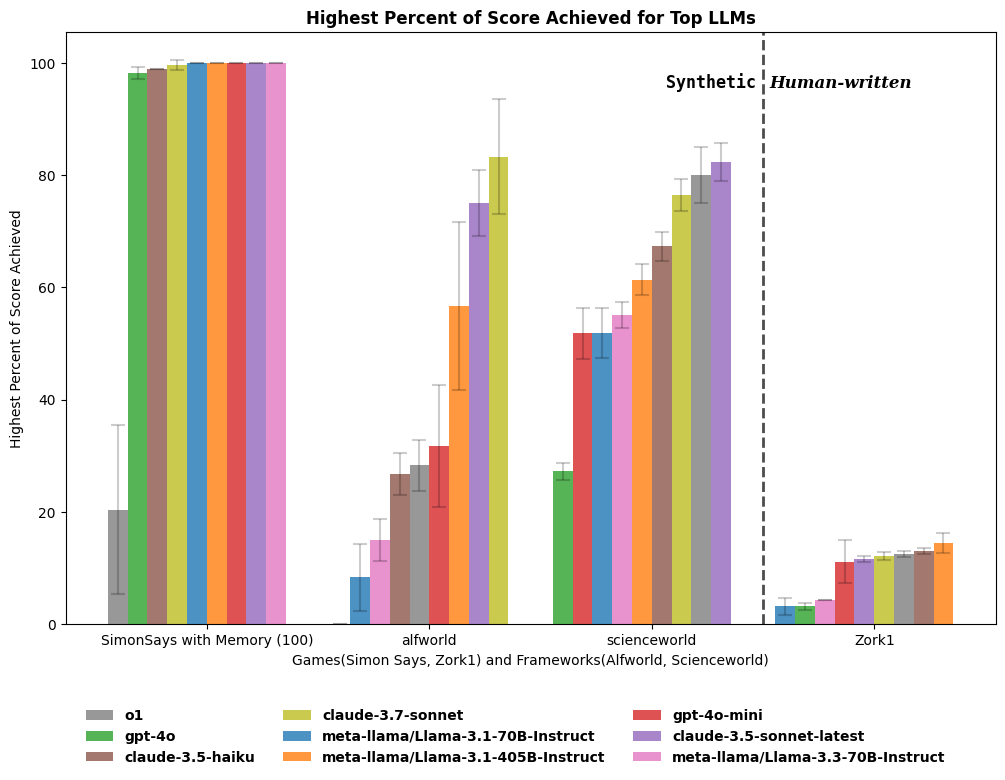

In [24]:
import matplotlib.pyplot as plt
import numpy as np
def make_bar_chart(llms, frameworks, error_bars = True, name_replacement_dict = {}, divider_idx = -1, plot_name = "bar_chart"):
    framework_indicies = []
    for framework in frameworks:
        if ":" in framework:
            # If there is a : in the framework, get it and split to get the names of all of the games that are to be graphed for that framework
            all_games = framework.split(":")[1].split(",")
            for game in all_games:
                assert game in framework_games[framework.split(":")[0]], f"Game {game} not in frameworks list"
            framework_indicies.append((fws.index(framework.split(":")[0]) + 1, all_games))
        else:
            framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset
    # framework_indicies = sorted(framework_indicies)

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = []
    filtered_stds_per_framework = []
    for i, row in enumerate(scores_per_framework):
        if row[0] not in llms: continue
        new_row_scores = [row[0]]
        new_row_stds = []
        for idx in framework_indicies: 
            if type(idx) == tuple:
                # If the index is a tuple, it means we have multiple games for that framework
                # Get the average score and std for those games
                game_scores = []
                game_stds = []
                for game in idx[1]:
                    framework = fws[idx[0] - 1]
                    game_scores_tokens = llm_framework_scores[row[0]][framework][game]
                    game_scores = []
                    for score_token in game_scores_tokens.values():
                        game_scores.append(score_token[0])

                    new_row_scores.append(np.mean(game_scores))
                    new_row_stds.append(np.std(game_scores, ddof=1))
            else:
                new_row_scores.append(row[idx])

                # new_row_stds.append(stds_per_framework[i][idx])
                # Calculate the std on a per-run basis
                # Get the games
                framework = fws[idx - 1]
                all_games_scores_tokens = llm_framework_scores[row[0]][framework]
                seeds_scores = {}
                # Get the averages per seed
                for _, seeds in all_games_scores_tokens.items():
                    for seed, score_tokens in seeds.items():
                        if seed not in seeds_scores.keys():
                            seeds_scores[seed] = [score_tokens[0]]
                        else:
                            seeds_scores[seed].append(score_tokens[0])
                summed_scores_per_seeds = []
                for seed, scores in seeds_scores.items():
                    summed_scores_per_seeds.append(np.mean(scores))
                new_row_stds.append(np.std(summed_scores_per_seeds, ddof=1))


        filtered_scores_per_framework.append(new_row_scores)
        filtered_stds_per_framework.append(new_row_stds)


    framework_names = []
    for framework in frameworks:
        if ":" not in framework:
            framework_names.append(framework)
        else:
            # Get the atcual framework name
            framework_name = framework.split(":")[0]
            # Then add all the games
            for game in framework.split(":")[1].split(","):
                if game in name_replacement_dict.keys():
                    framework_names.append(f"{name_replacement_dict[game]}")
                else:
                    framework_names.append(game)

    transposed_std_per_framework = np.transpose(filtered_stds_per_framework)
    llm_names = llms
    framework_scores_sets = []
    framework_std_sets = []
    for i, row in enumerate(np.transpose(filtered_scores_per_framework)[1:]):
        framework_scores_sets.append([float(score) * 100 for score in row])
        framework_std_sets.append([float(std) * 100 for std in transposed_std_per_framework[i]])
    # Sort scores, standard deviations, and LLM names for each framework
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []

    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llm_names)}

    for framework_name, framework_scores, framework_stds in zip(framework_names, framework_scores_sets, framework_std_sets):
        # Pair scores with their corresponding LLM names and standard deviations
        paired_data = list(zip(framework_scores, framework_stds, llm_names))
        
        # Sort the pairs by score
        paired_data.sort(key=lambda pair: pair[0])
        
        # Unzip the sorted pairs back into separate lists
        sorted_scores, sorted_stds, sorted_llms = zip(*paired_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar width and positions
    bar_width = 0.8 / len(llm_names)  # Dynamically adjust bar width based on the number of LLMs
    x = range(len(framework_names))  # X-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()

    # Plot bars for each framework
    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Add to legend only if this LLM hasn't been added yet
            if llm_name not in legend_added:
                label = llm_name
                legend_added.add(llm_name)
            else:
                label = ""
            
            # Calculate x position for the bar
            x_pos = x[i] + j * bar_width - (len(sorted_llms) * bar_width) / 2
            
            # Draw the bar
            ax.bar(
                x_pos,
                score,
                width=bar_width,
                label=label,
                color=llm_to_color[llm_name],  # Use consistent colors for each LLM
                alpha=0.8
            )
            
            if error_bars:
                # Add error bars
                ax.errorbar(
                    x_pos,
                    score,
                    yerr=std,
                    fmt='none',  # No line connecting error bars
                    ecolor='black',  # Color of error bars
                    capsize=5,  # Size of caps at the end of error bars
                    capthick=1.5,  # Thickness of caps
                    elinewidth=1.5,  # Thickness of error bar lines
                    alpha = 0.2
                )

    # Set x-axis labels and ticks
    ax.set_xticks(x)  # Center the ticks
    ax.set_xticklabels(framework_names)  # Set framework names as x-axis labels

    # Add labels and title
    ax.set_ylabel('Highest Percent of Score Achieved')
    ax.set_xlabel('Games(Simon Says, Zork1) and Frameworks(Alfworld, Scienceworld)')
    ax.set_title('Highest Percent of Score Achieved for Top LLMs', fontweight='bold')

    # Find index of 'scienceworld' and 'jericho' to place the dividing line
    try:
        # Get the index of the right most snythetic framework
        # non_synth_frameworks = ['jericho']
        # right_most_idx = 0
        # for framework_name in framework_names:
        #     print(framework_name)
        #     idx = framework_names.index(framework_name)
        #     print(idx)
        #     if idx > right_most_idx:
        #         non_synth = False
        #         for non_synth_framework in non_synth_frameworks:
        #             if non_synth_framework in framework_name:
        #                 non_synth = True
        #                 break
        #         if not non_synth:
        #             print("Updated")
        #             right_most_idx = idx

        # jer_idx = 0
        # for framework_name in framework_names:
        #     idx = framework_names.index(framework_name)
        #     if 'jericho' in framework_name:
        #         jer_idx = idx
        #         break

        jer_idx = divider_idx
        right_most_idx = jer_idx - 1

        # Make sure they're adjacent for the dividing line to make sense
        if jer_idx == right_most_idx + 1:
            # Calculate position between scienceworld and jericho
            divider_x = (x[right_most_idx] + x[jer_idx]) / 2
            
            # Get y-axis limits for the line height
            ymin, ymax = ax.get_ylim()
            line_height = ymax
            
            # Draw vertical divider line
            ax.axvline(x=divider_x, color='black', linestyle='--', linewidth=2, alpha=0.7)
            
            # Add "synthetic" and "human-written" labels
            y_text_pos = ymax * .9  # Position just above the top of the plot
            
            # Calculate positions for synthetic/human-written labels
            # Adjust these offsets to position the text properly
            spacing = 0.03
            synthetic_x = divider_x - spacing
            human_x = divider_x + spacing
            
            ax.text(synthetic_x, y_text_pos, 'Synthetic', ha='right', va='bottom', 
                   fontsize=12, fontweight='bold', fontfamily = 'monospace')
            ax.text(human_x, y_text_pos, 'Human-written', ha='left', va='bottom', 
                   fontsize=12, fontweight='bold', fontstyle='italic', fontfamily='serif')
            
            # Adjust top margin to make room for the labels
            plt.subplots_adjust(top=0.85)
    except ValueError:
        # If either framework isn't in the list, don't add the divider
        print("Note: Could not add divider - scienceworld and jericho must both be in frameworks list")

    # Add legend - placed outside to ensure it's visible and complete
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="",
        loc='upper center',
        bbox_to_anchor=(0.5, .02),  # Move the legend closer to the subplots
        ncol=3,
        frameon=False,
        fontsize='medium',  # Set the font size for the legend text
        prop={'weight': 'bold'} 
    )

    # Adjust layout
    # plt.tight_layout()
    # plt.savefig(plot_name + '.png')
    plt.savefig(plot_name + ".png", bbox_inches='tight', pad_inches = 0.5)
    # plt.show()
    # plt.close()

downsampled_llms = ['meta-llama/Llama-3.1-70B-Instruct',
 'meta-llama/Llama-3.1-405B-Instruct',
 'gpt-4o', 
#  'Qwen/Qwen2.5-72B-Instruct',
 'gpt-4o-mini',
 'claude-3.5-sonnet-latest',
 'claude-3.5-haiku',
#  'deepseek-ai/DeepSeek-R1-Distill-Llama-70B',
 'meta-llama/Llama-3.3-70B-Instruct', 
#  'o3-mini', 
 'o1', 
 'claude-3.7-sonnet']
name_replacement = {'TWXSimonSaysWithMemory100': 'SimonSays with Memory (100)', 'JerichoEnvZork1' : 'Zork1'}
downsampled_frameworks = ['textworld_express:TWXSimonSaysWithMemory100', 'alfworld', 'scienceworld', 'jericho:JerichoEnvZork1']
make_bar_chart(llms = downsampled_llms, 
                frameworks = downsampled_frameworks,
                error_bars = True, 
                name_replacement_dict = name_replacement,
                divider_idx = 3,
                plot_name = "all_framework_scores")
                # frameworks = fws)

### Horizontal version

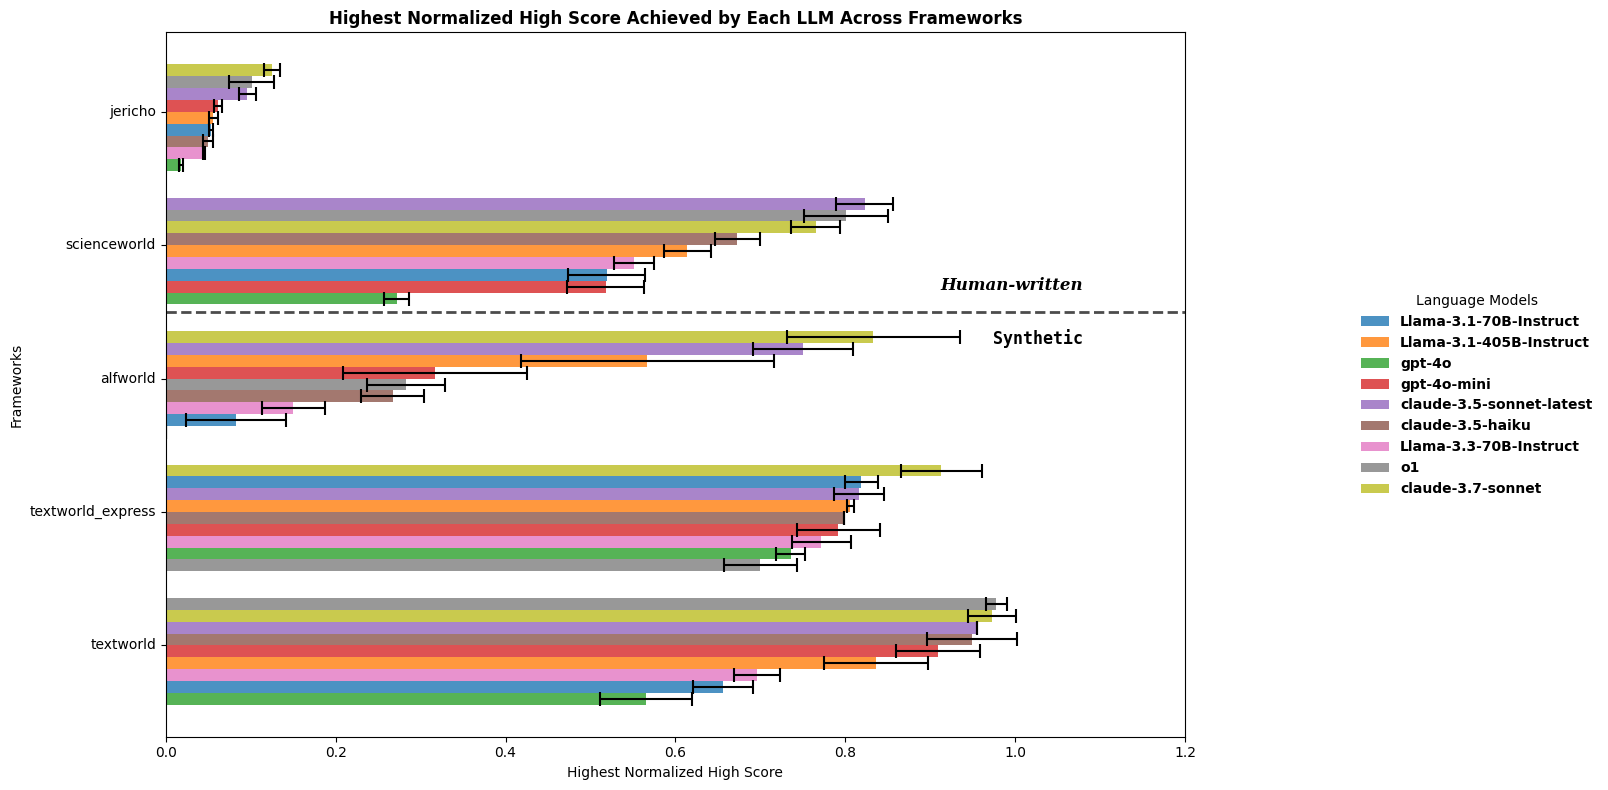

In [10]:
def make_bar_chart_horizontal(llms, frameworks, error_bars = True, name_replacement_dict = {}, divider_idx = -1, height_per_graph = 0.8):
    framework_indicies = []
    for framework in frameworks:
        if ":" in framework:
            # If there is a : in the framework, get it and split to get the names of all of the games that are to be graphed for that framework
            all_games = framework.split(":")[1].split(",")
            for game in all_games:
                assert game in framework_games[framework.split(":")[0]], f"Game {game} not in frameworks list"
            framework_indicies.append((fws.index(framework.split(":")[0]) + 1, all_games))
        else:
            framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = []
    filtered_stds_per_framework = []
    for i, row in enumerate(scores_per_framework):
        if row[0] not in llms: continue
        new_row_scores = [row[0]]
        new_row_stds = []
        for idx in framework_indicies: 
            if type(idx) == tuple:
                # If the index is a tuple, it means we have multiple games for that framework
                # Get the average score and std for those games
                game_scores = []
                game_stds = []
                for game in idx[1]:
                    framework = fws[idx[0] - 1]
                    game_scores_tokens = llm_framework_scores[row[0]][framework][game]
                    game_scores = []
                    for score_token in game_scores_tokens.values():
                        game_scores.append(score_token[0])

                    new_row_scores.append(np.mean(game_scores))
                    new_row_stds.append(np.std(game_scores))
            else:
                new_row_scores.append(row[idx])
                # new_row_stds.append(stds_per_framework[i][idx])
                # new_row_stds.append(stds_per_framework[i][idx])
                # Calculate the std on a per-run basis
                # Get the games
                framework = fws[idx - 1]
                all_games_scores_tokens = llm_framework_scores[row[0]][framework]
                seeds_scores = {}
                # Get the averages per seed
                for _, seeds in all_games_scores_tokens.items():
                    for seed, score_tokens in seeds.items():
                        if seed not in seeds_scores.keys():
                            seeds_scores[seed] = [score_tokens[0]]
                        else:
                            seeds_scores[seed].append(score_tokens[0])
                summed_scores_per_seeds = []
                for seed, scores in seeds_scores.items():
                    summed_scores_per_seeds.append(np.mean(scores))
                new_row_stds.append(np.std(summed_scores_per_seeds, ddof=1))

        filtered_scores_per_framework.append(new_row_scores)
        filtered_stds_per_framework.append(new_row_stds)

    framework_names = []
    for framework in frameworks:
        if ":" not in framework:
            framework_names.append(framework)
        else:
            # Get the atcual framework name
            framework_name = framework.split(":")[0]
            # Then add all the games
            for game in framework.split(":")[1].split(","):
                if game in name_replacement_dict.keys():
                    framework_names.append(f"{name_replacement_dict[game]}")
                else:
                    framework_names.append(game)


    transposed_std_per_framework = np.transpose(filtered_stds_per_framework)
    llm_names = llms
    framework_scores_sets = []
    framework_std_sets = []
    for i, row in enumerate(np.transpose(filtered_scores_per_framework)[1:]):
        framework_scores_sets.append([float(score) for score in row])
        framework_std_sets.append([float(std) for std in transposed_std_per_framework[i]])
    # Sort scores, standard deviations, and LLM names for each framework
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []

    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llm_names)}

    for framework_name, framework_scores, framework_stds in zip(framework_names, framework_scores_sets, framework_std_sets):
        # Pair scores with their corresponding LLM names and standard deviations
        paired_data = list(zip(framework_scores, framework_stds, llm_names))
        
        # Sort the pairs by score
        paired_data.sort(key=lambda pair: pair[0])
        
        # Unzip the sorted pairs back into separate lists
        sorted_scores, sorted_stds, sorted_llms = zip(*paired_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    total_items = len(framework_names)
    height_per_item = height_per_graph  # inches per game/framework
    fig_height = max(8, total_items * height_per_item)

    # Create a bar chart with extra space on right for legend
    fig, ax = plt.subplots(figsize=(14, fig_height))  # Increased width to accommodate legend

    # Bar width and positions
    bar_width = 0.8 / len(llm_names)  # Dynamically adjust bar width based on the number of LLMs
    y = range(len(framework_names))  # Y-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()

    # Plot bars for each framework
    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Add to legend only if this LLM hasn't been added yet
            if llm_name not in legend_added:
                label = llm_name.split('/')[-1] if '/' in llm_name else llm_name  # Use shorter names
                legend_added.add(llm_name)
            else:
                label = ""
            
            # Calculate y position for the bar
            y_pos = y[i] + j * bar_width - (len(sorted_llms) * bar_width) / 2
            
            # Draw the bar
            ax.barh(
                y_pos,
                score,
                height=bar_width,
                label=label,
                color=llm_to_color[llm_name],
                alpha=0.8
            )
            
            if error_bars:
                # Add error bars
                ax.errorbar(
                    score,
                    y_pos,
                    xerr=std,
                    fmt='none',
                    ecolor='black',
                    capsize=5,
                    capthick=1.5,
                    elinewidth=1.5
                )

    # Set y-axis labels and ticks with 60-degree rotation
    ax.set_yticks(y)
    # ax.set_yticklabels(framework_names, rotation=60, ha='right', va='center')  # 60-degree angle
    ax.set_yticklabels(framework_names, ha='right', va='center')  # 60-degree angle

    # Add labels and title
    ax.set_xlabel('Highest Normalized High Score')
    ax.set_ylabel('Frameworks')
    ax.set_title('Highest Normalized High Score Achieved by Each LLM Across Frameworks', fontweight='bold')
    ax.set_xlim(0, 1.2)

    # Find index of 'scienceworld' and 'jericho' to place the dividing line
    try:
        # Get the index of the right most synthetic framework
        # non_synth_frameworks = ['jericho']
        # right_most_idx = 0
        # for framework_name in framework_names:
        #     idx = framework_names.index(framework_name)
        #     if idx > right_most_idx:
        #         non_synth = False
        #         for non_synth_framework in non_synth_frameworks:
        #             if non_synth_framework in framework_name:
        #                 non_synth = True
        #                 break
        #         if not non_synth:
        #             right_most_idx = idx

        # jer_idx = 0
        # for framework_name in framework_names:
        #     idx = framework_names.index(framework_name)
        #     if 'jericho' in framework_name:
        #         jer_idx = idx
        #         break

        jer_idx = divider_idx
        right_most_idx = jer_idx - 1

        # Make sure they're adjacent for the dividing line to make sense
        if jer_idx == right_most_idx + 1:
            # Calculate position between scienceworld and jericho
            divider_y = (y[right_most_idx] + y[jer_idx]) / 2
            
            # Get x-axis limits for the line width
            xmin, xmax = ax.get_xlim()
            
            # Draw horizontal divider line
            ax.axhline(y=divider_y, color='black', linestyle='--', linewidth=2, alpha=0.7)
            
            # Add "synthetic" and "human-written" labels
            x_text_pos = xmax * 0.9
            
            # Calculate positions for synthetic/human-written labels
            spacing = 0.2
            synthetic_y = divider_y - spacing
            human_y = divider_y + spacing
            
            # Text positioned to the right of the dividing line
            ax.text(x_text_pos, synthetic_y, 'Synthetic', ha='right', va='center', 
                   fontsize=12, fontweight='bold', fontfamily = 'monospace')
            ax.text(x_text_pos, human_y, 'Human-written', ha='right', va='center', 
                   fontsize=12, fontweight='bold', fontstyle='italic', fontfamily='serif')
    except ValueError:
        # If either framework isn't in the list, don't add the divider
        print("Note: Could not add divider - scienceworld and jericho must both be in frameworks list")

    # Add legend to the right side in a single column
    handles, labels = ax.get_legend_handles_labels()
    # Sort to ensure they appear in the original order
    by_label = dict(zip(labels, handles))
    sorted_labels = []
    for llm in llms:
        short_name = llm.split('/')[-1] if '/' in llm else llm
        if short_name in labels:
            sorted_labels.append(short_name)
        
    sorted_handles = [by_label[label] for label in sorted_labels if label in by_label]
    
    # Place legend on the right side in a single column
    fig.legend(
        sorted_handles, sorted_labels,
        title="Language Models",
        loc='center right',
        bbox_to_anchor=(1.15, 0.5),  # Position to the right of the plot
        ncol=1,  # Single column
        frameon=False,
        fontsize='small',
        prop={'weight': 'bold'}
    )

    # Adjust layout - reduce right padding to accommodate the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # Leave space on the right for the legend
    
    plt.show()

framework_games['textworld_express']
all_frameworks_by_games = []
for framework, games in framework_games.items():
    all_frameworks_by_games.append(framework + ":" + ",".join(games))

make_bar_chart_horizontal(llms = downsampled_llms, 
                # frameworks = all_frameworks_by_games,
                frameworks = fws,
                error_bars = True, 
                name_replacement_dict = name_replacement,
                divider_idx = 3)

### Make horizontal bar charts per game

In [16]:
def make_game_bar_charts(llms, framework, games=None, height_per_game = 0.5, plot_name = "placeholder"):
    """
    Creates horizontal bar charts showing LLM performance for each game in a specific framework.
    
    Args:
        llms: List of LLM names to include
        framework: The specific framework to analyze
        games: Optional list of games to include (if None, will use all games in the framework)
    """
    # If no games specified, get all games for the framework
    if games is None:
        games = framework_games[framework]
    
    # Create a color mapping for LLMs for consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llms)}
    
    # Create a figure with subplots - one per game
    n_games = len(games)
    fig_height = n_games * height_per_game  # Dynamic height based on number of games
    fig, axes = plt.subplots(n_games, 1, figsize=(12, fig_height), sharex=True, 
                           constrained_layout=False)
    
    # If there's only one game, make sure axes is still iterable
    if n_games == 1:
        axes = [axes]
    
    # Keep track of the maximum score to set consistent x-axis limits
    max_score = 0
    
    # Process each game
    for game_idx, game in enumerate(games):
        ax = axes[game_idx]
        
        # Collect scores and stds for this game across all LLMs
        game_scores = []
        game_stds = []
        valid_llms = []
        
        for llm in llms:
            try:
                # Get all seeds for this game
                seeds = llm_framework_scores[llm][framework][game]
                
                # Extract scores from all seeds
                scores = [seed_data[0] for seed_data in seeds.values()]
                
                # Calculate mean and std
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                
                game_scores.append(mean_score)
                game_stds.append(std_score)
                valid_llms.append(llm)
                
                # Update max score for x-axis scaling
                if mean_score + std_score > max_score:
                    max_score = mean_score + std_score
                    
            except (KeyError, ValueError):
                # Skip if LLM doesn't have data for this game
                continue
        
        # Sort scores, stds, and LLMs together (highest score first)
        sorted_data = sorted(zip(game_scores, game_stds, valid_llms), key=lambda x: x[0], reverse=False)
        
        # Unpack the sorted data
        if sorted_data:  # Check if there's any data
            sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        else:
            # Skip this game if no data
            ax.set_title(f"{game} (No data)")
            continue
            
        # Set y positions for bars
        y_positions = range(len(sorted_llms))
        
        # Draw horizontal bars
        for i, (llm, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Draw the bar
            ax.barh(
                i,
                score,
                height=1.0,
                label=llm if game_idx == 0 and i == 0 else "",  # Only add to legend once
                color=llm_to_color[llm],
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                score,
                i,
                xerr=std,
                fmt='none',
                ecolor='black',
                capsize=3,
                capthick=1,
                elinewidth=1
            )
            
            # Add score value at the end of each bar
            ax.text(
                score + std + 0.01,  # Slight offset from end of error bar
                i,
                f"{score:.3f}±{std:.3f}",
                va='center',
                fontsize=8
            )
        
        # Set y-ticks to be the LLM names
        ax.set_yticks(y_positions)
        shortened_llm_names = [llm.split('/')[-1] for llm in sorted_llms]  # Get just the model name without path
        ax.set_yticklabels(shortened_llm_names)
        
        # Set title for this subplot
        ax.set_title(game)
        
        # Add grid lines
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Only show x-label on the bottom plot
        if game_idx == n_games - 1:
            ax.set_xlabel('Normalized Score')
    
    # Set consistent x-axis limits
    for ax in axes:
        ax.set_xlim(0, max_score * 1.2)  # Add 20% padding
    
    
    # plt.suptitle(f'Performance Across Games in {framework.capitalize()}', fontsize=16, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(
        hspace=0.1,       # Space between subplots (reduce this if needed)
        # top=2.0,         # Top margin (increase this to move title down)
        bottom=0.05,      # Bottom margin
        left=0.1,         # Left margin
        right=0.9         # Right margin
    )
    
    plt.savefig(plot_name + '.png')
    # plt.show()
    plt.close()
    
    return fig, axes

# Example usage for one framework
framework_to_analyze = 'scienceworld'  # You can replace with any framework from fws
selected_games = framework_games[framework_to_analyze]  # Limit to first 5 games to avoid overcrowding
framework_save_title = {'textworld_express': 'textworld_express_all_games', 'textworld': 'textworld_all_games', 'alfworld': 'alfworld_all_games', 'scienceworld': 'scienceworld_all_games', 'jericho': 'jericho_all_games'}
# Create the bar charts

for framework, title in framework_save_title.items():
    make_game_bar_charts(
        llms=downsampled_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 4.0,
        plot_name=title
    )

In [28]:
def make_game_bar_charts(llms, framework, games=None, height_per_game=0.5, plot_name="placeholder"):
    """
    Creates horizontal bar charts showing LLM performance for each game in a specific framework.
    
    Args:
        llms: List of LLM names to include
        framework: The specific framework to analyze
        games: Optional list of games to include (if None, will use all games in the framework)
    """
    # If no games specified, get all games for the framework
    if games is None:
        games = framework_games[framework]
    
    # Create a color mapping for LLMs for consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llms)}
    
    # Create a figure with subplots - one per game
    n_games = len(games)
    fig_height = n_games * height_per_game  # Dynamic height based on number of games
    fig, axes = plt.subplots(n_games, 1, figsize=(12, fig_height), sharex=True, 
                           constrained_layout=False)
    
    # If there's only one game, make sure axes is still iterable
    if n_games == 1:
        axes = [axes]
    
    # Keep track of the maximum score to set consistent x-axis limits
    max_score = 0
    
    # Process each game
    for game_idx, game in enumerate(games):
        ax = axes[game_idx]
        
        # Collect scores and stds for this game across all LLMs
        game_scores = []
        game_stds = []
        valid_llms = []
        
        for llm in llms:
            try:
                # Get all seeds for this game
                seeds = llm_framework_scores[llm][framework][game]
                
                # Extract scores from all seeds
                scores = [seed_data[0] for seed_data in seeds.values()]
                
                # Calculate mean and std
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                
                game_scores.append(mean_score)
                game_stds.append(std_score)
                valid_llms.append(llm)
                
                # Update max score for x-axis scaling
                if mean_score + std_score > max_score:
                    max_score = mean_score + std_score
                    
            except (KeyError, ValueError):
                # Skip if LLM doesn't have data for this game
                continue
        
        # Sort scores, stds, and LLMs together (highest score first)
        sorted_data = sorted(zip(game_scores, game_stds, valid_llms), key=lambda x: x[0], reverse=False)
        
        # Unpack the sorted data
        if sorted_data:  # Check if there's any data
            sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        else:
            # Skip this game if no data
            ax.set_title(f"{game} (No data)")
            continue
            
        # Set y positions for bars
        y_positions = range(len(sorted_llms))
        
        # Draw horizontal bars
        for i, (llm, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Draw the bar
            ax.barh(
                i,
                score,
                height=0.8,  # Reduced bar height to allow more space for text
                label=llm if game_idx == 0 and i == 0 else "",  # Only add to legend once
                color=llm_to_color[llm],
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                score,
                i,
                xerr=std,
                fmt='none',
                ecolor='black',
                capsize=3,
                capthick=1,
                elinewidth=1
            )
            
            # Add score value at the end of each bar (now with percentage and split into two lines)
            # Convert to percentage and format
            score_pct = score * 100
            std_pct = std * 100
            
            # Create a two-line label with percentage
            label_score = f"{score_pct:.1f}%"
            label_std = f"±{std_pct:.1f}%"
            
            # Position the text with increased vertical offset for the two lines
            # The key change is increasing the vertical offset (i - 0.25 vs i + 0.25)
            spacing = .35
            ax.text(
                score + std + 0.01,  # Horizontal position
                i - spacing,            # Increased vertical spacing (more negative)
                label_std,
                va='bottom',
                fontsize=6           # Slightly reduced font size
            )
            ax.text(
                score + std + 0.01,  # Same horizontal position
                i + spacing,            # Increased vertical spacing (more positive)
                label_score, 
                va='top',
                fontsize=6           # Slightly reduced font size
            )
        
        # Set y-ticks to be the LLM names
        ax.set_yticks(y_positions)
        shortened_llm_names = [llm.split('/')[-1] for llm in sorted_llms]  # Get just the model name without path
        ax.set_yticklabels(shortened_llm_names)
        
        # Set title for this subplot
        ax.set_title(game)
        
        # Add grid lines
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Only show x-label on the bottom plot
        if game_idx == n_games - 1:
            ax.set_xlabel('Normalized Score')
    
    # Set consistent x-axis limits and show as percentages
    for ax in axes:
        ax.set_xlim(0, max_score * 1.2)  # Add 20% padding
        
        # Format x-axis ticks as percentages
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(
        hspace=0.4,       # Increased space between subplots for better visualization
        bottom=0.15,      # Bottom margin
        left=0.15,        # Left margin for labels
        right=0.85,       # Right margin
        top=0.95          # Top margin
    )
    
    # Save with bbox_inches to ensure nothing is cut off
    plt.savefig(plot_name + '.png', bbox_inches='tight', pad_inches=0.5)
    plt.close()
    
    return fig, axes

framework_save_title = {'textworld_express': 'textworld_express_all_games', 'textworld': 'textworld_all_games', 'alfworld': 'alfworld_all_games', 'scienceworld': 'scienceworld_all_games', 'jericho': 'jericho_all_games'}
# Create the bar charts

for framework, title in framework_save_title.items():
    make_game_bar_charts(
        llms=downsampled_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 4.0,
        plot_name=title
    )

In [ ]:
make_game_bar_charts(
        llms=downsampled_llms, 
        framework=framework,
        games=framework_games[framework],
        height_per_game = 4.0,
        plot_name=title
    )

## New Code: Experimental

Get the top llm per game

In [16]:
tmp = regen_and_filter_df(all_games_required = True, all_seeds_required = True, print_counts = False)
print(tmp.keys())

Requiring all games...
Requiring all seeds...(implicitly requiring all games too)
Index(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves',
       'episode/normalized_score', 'episode/rollout', 'episode/score',
       'final/Duration', 'final/Game Max Score', 'final/Highscore',
       'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves',
       'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins',
       'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework',
       'max_steps', 'conversation', 'admissible_commands', 'tags',
       'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed',
       'context_limit', 'episode/highscore', 'episode/normalized_highscore',
       'episode/token_usage', 'agent_type', 'version', 'reasoning_effort'],
      dtype='object')


In [17]:
all_fws = tmp['framework'].unique()
framework_best_llm = {}
for fw in all_fws:
    llm_scores = tmp[tmp['framework'] == fw]
    framework_scores = llm_scores.groupby("llm")['episode/normalized_highscore'].mean().reset_index()
    top_score_row = framework_scores['episode/normalized_highscore'].idxmax()
    top_llm = framework_scores.loc[top_score_row, 'llm']
    framework_best_llm[fw] = top_llm    

print(framework_best_llm)

{'scienceworld': 'claude-3.5-sonnet-latest', 'textworld': 'o1', 'alfworld': 'claude-3.7-sonnet (react)', 'jericho': 'claude-3.7-sonnet (zero-shot)', 'textworld_express': 'claude-3.7-sonnet (zero-shot)'}


In [18]:
def save_optimal_logs(base_path = '/root/trajectories/'):
    all_convos = []
    for framework, llm in framework_best_llm.items():
        for data in filtered_runs_data:
            if data['llm'] == llm and data['framework'] == framework:
                convo_dict = {}
                for i, step in enumerate(data['rollout']):
                    turn = {}
                    turn['user'] = step[5]
                    turn['assistant'] = step[6]
                    convo_dict["step " + str(i)] = turn
                # Save the conversation to a JSON file 
                with open(base_path + framework + "_" + data['game'] + "_" + llm.split("/")[-1] + "_" + str(data['seed']) +  ".json", 'w') as f:
                    json.dump(convo_dict, f, indent=4)  
                all_convos.append(convo_dict)
    return all_convos
                
all_convos = save_optimal_logs()

In [19]:
def get_partial_trajectories(base_path = '/root/trajectories/'):
    all_datapoints = {}
    longed_convo = 0
    for framework, llm in framework_best_llm.items():
        data_points = []
        for data in filtered_runs_data:
            if data['llm'] == llm and data['framework'] == framework:
                convo_history = ""
                for i, step in enumerate(data['rollout']):
                    convo_history += step[5] + "\n"
                    data_dict = {'prompt': convo_history, 'response': step[6]}
                    convo_history += step[6] + "\n"
                    data_points.append(data_dict)
                    if len(convo_history) > longed_convo: longed_convo = len(convo_history)

        all_datapoints[framework] = data_points
    print("Longest trajectory:", longed_convo)
    return all_datapoints

all_datapoints = get_partial_trajectories()
total = 0
for framework, data_points in all_datapoints.items():
    print(f'{framework}: {len(data_points)} data points')
    total += len(data_points)
print(f'Total data points: {total}')


Longest trajectory: 51392
scienceworld: 8067 data points
textworld: 1118 data points
alfworld: 2871 data points
jericho: 26986 data points
textworld_express: 3367 data points
Total data points: 42409


In [23]:
def create_data_splits(data, test_percent = .2, subsample_train = 1, save_path = '/root/'):
    test_set = []
    train_set = []
    random.seed(12)
    for datum in data:
        random.shuffle(datum)
        split_index = int(len(datum) * test_percent)
        test_set += datum[:split_index]
        train_set += datum[split_index:]

    random.shuffle(train_set)
    random.shuffle(test_set)

    with open("test.jsonl", "w") as jsonl_file:
        for item in test_set:
            jsonl_file.write(json.dumps(item) + "\n")
    
    with open("valid.jsonl", "w") as jsonl_file:
        for item in test_set:
            jsonl_file.write(json.dumps(item) + "\n")

    split_index = int(len(train_set) * subsample_train)
    with open("train.jsonl", "w") as jsonl_file:
        for item in train_set[:split_index]:
            jsonl_file.write(json.dumps(item) + "\n")
    print("Train set:", len(train_set[:split_index]))
    print("Test set:", len(test_set))

create_data_splits(list(all_datapoints.values()), subsample_train=.5)

Train set: 16964
Test set: 8480
